**Name:** Trini Kui

**StudentID:** 21204004

In [30]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, RobustScaler, FunctionTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
import pickle
import matplotlib.pyplot as plt
#%matplotlib inline

# imports necessary for dimensionality reduction
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from sklearn import svm
from sklearn.manifold import Isomap
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# regression algorithms
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.tree import DecisionTreeRegressor

# metrics for evaluating regression models
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import seaborn as sns

import warnings
warnings.filterwarnings("ignore") #ignore all the warnings

# Exploratory Data Analysis

In [2]:
df = pd.read_csv("./insurance.csv")
df.head()

age  gender     bmi  children smoker     region  insurance_cost
0   18    male  33.770         1     no  southeast      1725.55230
1   18    male  34.100         0     no  southeast      1137.01100
2   18  female  26.315         0     no  northeast      2198.18985
3   18  female  38.665         2     no  northeast      3393.35635
4   18  female  35.625         0     no  northeast      2211.13075

I will aim to **train the regression algorithms to predict the `insurance_cost`** based on the other attributes.

First, we will look at categorical columns

In [4]:
display(df['gender'].value_counts())
display(df['smoker'].value_counts())
display(df['region'].value_counts())

male      676
female    662
Name: gender, dtype: int64

no     1064
yes     274
Name: smoker, dtype: int64

southeast    364
northwest    325
southwest    325
northeast    324
Name: region, dtype: int64

Look for missing values - none are missing, good. 

In [5]:
df.isna().sum()

age               0
gender            0
bmi               0
children          0
smoker            0
region            0
insurance_cost    0
dtype: int64

In [6]:
df.describe()

age          bmi     children  insurance_cost
count  1338.000000  1338.000000  1338.000000     1338.000000
mean     39.207025    30.663397     1.094918    13270.422265
std      14.049960     6.098187     1.205493    12110.011237
min      18.000000    15.960000     0.000000     1121.873900
25%      27.000000    26.296250     0.000000     4740.287150
50%      39.000000    30.400000     1.000000     9382.033000
75%      51.000000    34.693750     2.000000    16639.912515
max      64.000000    53.130000     5.000000    63770.428010

All the values are in the positives, but we'll probably need to scale the numerical attributes later to make them more comparable.

Next, we'll look for outliers...

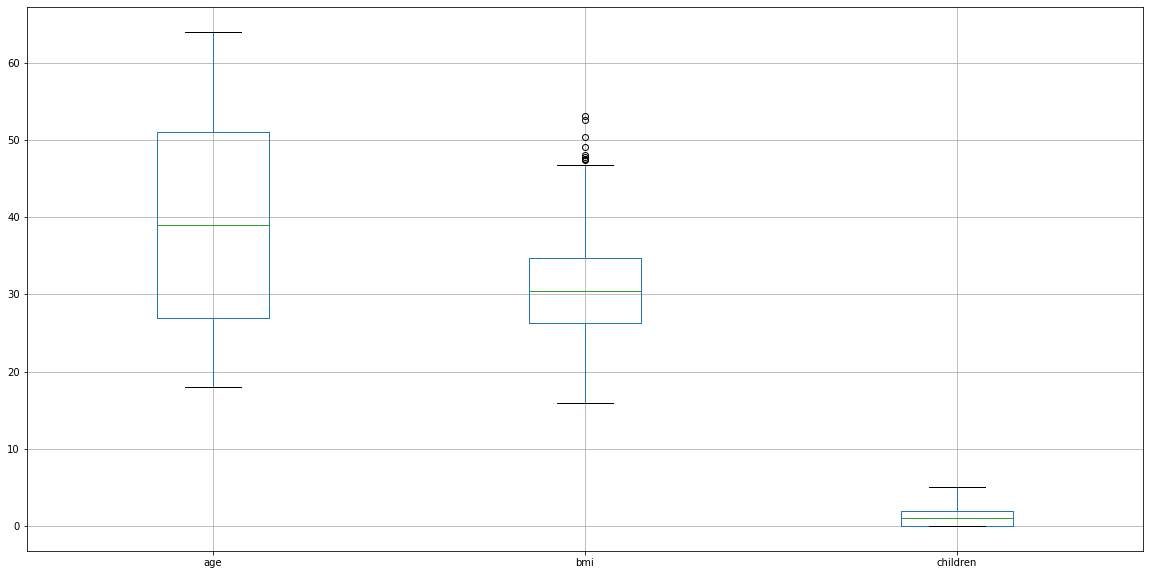

In [7]:
df.loc[:,df.columns != 'insurance_cost'].boxplot(figsize=(20,10)) #shows all columns except the target 'type' column
plt.show()

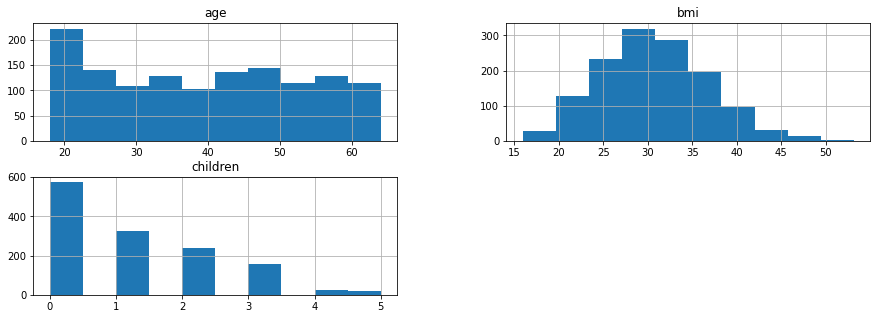

In [15]:
df.loc[:,df.columns != 'insurance_cost'].hist(figsize=(15,5))
plt.show()

`bmi` seems to have quite a bit of outliers so we'll use a **robust scalar** and **log** to deal with the outliers and distribution shape. The other columns don't seem to have outliers so I can use **standard scalar**.

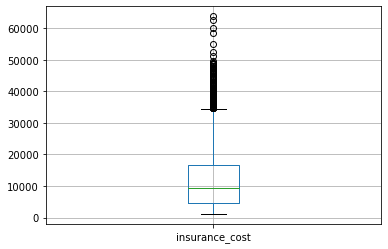

In [27]:
df.boxplot(column=['insurance_cost'])
plt.show()

`insurance_cost`, the predictor has many outliers, but it still makes sense as certain attributes (or a certain combination of them) that an individual has may cause their insurance cost to increase. For example below, smokers will have a higher insurance cost. For non-smokers that are outliers, they may have other attributes that causes them to have higher insurance cost.

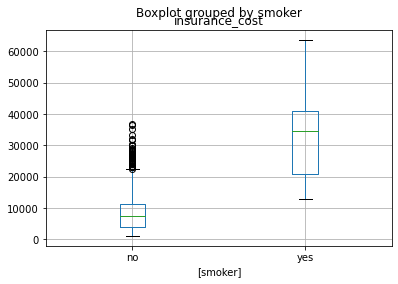

In [28]:
df.boxplot(column=['insurance_cost'], by=['smoker'])
plt.show()

# Data Preparation

Before we scale or transform anything, I will first encode the categorical attributes. 

- `gender`/`smoker`, there's no order to them so I will one-hot encode it. Since there's only 2 options, I will use drop_first = True
-  `region`, one-hot encode since there's no order too but with drop_first=False since there's 4 different categories

In [3]:
df = pd.get_dummies(df, columns=['gender','smoker'], drop_first=True)
df.head()

age     bmi  children     region  insurance_cost  gender_male  smoker_yes
0   18  33.770         1  southeast      1725.55230            1           0
1   18  34.100         0  southeast      1137.01100            1           0
2   18  26.315         0  northeast      2198.18985            0           0
3   18  38.665         2  northeast      3393.35635            0           0
4   18  35.625         0  northeast      2211.13075            0           0

In [4]:
df = pd.get_dummies(df, columns=['region'], drop_first=False)
df.head()

age     bmi  children  insurance_cost  gender_male  smoker_yes  \
0   18  33.770         1      1725.55230            1           0   
1   18  34.100         0      1137.01100            1           0   
2   18  26.315         0      2198.18985            0           0   
3   18  38.665         2      3393.35635            0           0   
4   18  35.625         0      2211.13075            0           0   

   region_northeast  region_northwest  region_southeast  region_southwest  
0                 0                 0                 1                 0  
1                 0                 0                 1                 0  
2                 1                 0                 0                 0  
3                 1                 0                 0                 0  
4                 1                 0                 0                 0

In [5]:
col_all = list(df.columns)
col_all = col_all[:-1] #all columns except the predictor column 'type'

col_outlier = ['bmi'] #features with outliers
col_no_outlier = list(set(col_all) - set(col_outlier)) #all other features

In [13]:
#### From Etivity 4 ####

# Add column names after splitting dataset into train and test
class AddColumnNames(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return pd.DataFrame(data=X, columns=self.columns)

# Select particular group of columns


class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        assert isinstance(X, pd.DataFrame)
        return X[self.columns]


preprocess_pipeline = make_pipeline(
    AddColumnNames(columns=col_all),
    FeatureUnion(transformer_list=[
        ("outlier_columns", make_pipeline(
            ColumnSelector(columns=col_outlier),
            FunctionTransformer(np.log, validate=True),
            RobustScaler()
        )),
        ("no_outlier_columns", make_pipeline(
            ColumnSelector(columns=col_no_outlier),
            StandardScaler()
        ))
    ])
)

Split the data into train and test sets before we perform any scaling/transformation to prevent data snooping.

In [10]:
y = df['insurance_cost']
X = df.drop('insurance_cost', axis=1).values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=55)

# Task 2

Repeat the experiment in Lab5 - Regression and Dimensionality Reduction.ipynb with insurance.csv and draw conclusions from the results you observe in a markdown cell. Add a third regression algorithm of your choice. Describe how it compares to Random Forest and Linear regression in a markdown cell (max 250 words in a markdown cell).

*Exemplary*:
- Random Forest and Linear Regression trained correctly with the insurance dataset
- A third regression algorithm attempted successfully but not compared correctly to the other regression algorithms.

The 3 regression models are **Random Forest, Linear Regression and Decision Tree**.

We will attempt three different dimensionality reduction methods and we will let the grid search pick the best one. These are:

- Principal Component Analysis (PCA)
- Recursive Feature Elimination (RFE) with estimator `svm.SVR`
- Recursive Feature Elimination (RFE) with estimator `LinearRegression`

## Random Forest

In [42]:
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline),
                       ('reduce_dim', 'passthrough'),
                       ('regresson', RandomForestRegressor(n_estimators=10))])

N_FEATURES_OPTIONS = [2, 6, 11]
MAX_DEPTH_OPTIONS = [2, 4, 6, 8, 10]

param_grid = [
    {
        'reduce_dim': [PCA(iterated_power=7)],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'regresson__max_depth': MAX_DEPTH_OPTIONS
    },
    {
        'reduce_dim': [RFE(svm.SVR(kernel='linear', gamma='auto')), RFE(LinearRegression())],
        'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS,
        'regresson__max_depth': MAX_DEPTH_OPTIONS
    }
]

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)

print("Best CV score = %0.4f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
RF_best_params = search.best_params_
RF_best_model = search.best_estimator_

Best CV score = 0.8533:
Best parameters:  {'reduce_dim': RFE(estimator=LinearRegression(), n_features_to_select=11), 'reduce_dim__n_features_to_select': 11, 'regresson__max_depth': 4}


## Linear Regression

In [43]:
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), 
                       ('reduce_dim', 'passthrough'),
                       ('regresson', LinearRegression())])

NORMALIZE_OPTIONS = [False, True]

param_grid = [
    {
        'reduce_dim': [PCA(iterated_power=7)],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'regresson__normalize': NORMALIZE_OPTIONS
    },
    {
        'reduce_dim': [RFE(svm.SVR(kernel='linear', gamma='auto')),RFE(LinearRegression())],
        'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS,
        'regresson__normalize': NORMALIZE_OPTIONS
    }  
]

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)
print("Best CV score = %0.4f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
LR_best_params = search.best_params_
LR_best_model = search.best_estimator_

Best CV score = 0.7371:
Best parameters:  {'reduce_dim': RFE(estimator=SVR(gamma='auto', kernel='linear'), n_features_to_select=6), 'reduce_dim__n_features_to_select': 6, 'regresson__normalize': True}


## Decision Tree

Random Forests are typically better than Decision Tree since RF has multiple single trees. I wanted to see how much worse decision tree would perform though, so I will look at it here. 

In [44]:
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline),
                       ('reduce_dim', 'passthrough'),
                       ('regresson', DecisionTreeRegressor())])

MAX_DEPTH_OPTIONS = [2, 4, 6, 8, 10]
CRITERION_OPTIONS = ['squared_error','friedman_mse','absolute_error','poisson']


param_grid = [
    {
        'reduce_dim': [PCA(iterated_power=7)],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'regresson__max_depth': MAX_DEPTH_OPTIONS,
        'regresson__criterion': CRITERION_OPTIONS,
    },
    {
        'reduce_dim': [RFE(svm.SVR(kernel='linear', gamma='auto')), RFE(LinearRegression())],
        'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS,
        'regresson__max_depth': MAX_DEPTH_OPTIONS,
        'regresson__criterion': CRITERION_OPTIONS,
    }
]

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)
print("Best CV score = %0.4f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
DT_best_params = search.best_params_
DT_best_model = search.best_estimator_

Best CV score = 0.8411:
Best parameters:  {'reduce_dim': RFE(estimator=SVR(gamma='auto', kernel='linear'), n_features_to_select=6), 'reduce_dim__n_features_to_select': 6, 'regresson__criterion': 'friedman_mse', 'regresson__max_depth': 4}


## Comparison

Now we can evaluate the best models found by the grid search on the test dataset and compare their metrics:

- mean squared error (MSE)
- mean absolute error (MAE)
- 1-relative squared error (R2)

to choose the better regressor for our problem.

In [19]:
### From Lab 5 ###

def evaluate_model(X_test, y_test, model):
    
    # compute predictiond for the test set
    _predicted_values = model.predict(X_test)
        
    # compute metrics
    _mse = mean_squared_error(y_test, _predicted_values)
    _mae = mean_absolute_error(y_test, _predicted_values)
    _r2 = r2_score(y_test, _predicted_values)
            
    return _mse, _mae, _r2

In [45]:
RF_mse, RF_mae, RF_r2 = evaluate_model(X_test, y_test, RF_best_model)
LR_mse, LR_mae, LR_r2 = evaluate_model(X_test, y_test, LR_best_model)
DT_mse, DT_mae, DT_r2 = evaluate_model(X_test, y_test, DT_best_model)

In [46]:
RF_metrics = np.array([RF_mse, RF_mae, RF_r2])
LR_metrics = np.array([LR_mse, LR_mae, LR_r2])
DT_metrics = np.array([DT_mse, DT_mae, DT_r2])
index = ['MSE', 'MAE', 'R2']
df_metrics = pd.DataFrame({'Random Forest': RF_metrics,
                          'Linear': LR_metrics, 'Decision Tree': DT_metrics}, index=index)
df_metrics

Random Forest        Linear  Decision Tree
MSE   1.780119e+07  3.260676e+07   1.988726e+07
MAE   2.376836e+03  4.137875e+03   2.669559e+03
R2    8.751804e-01  7.713658e-01   8.605532e-01

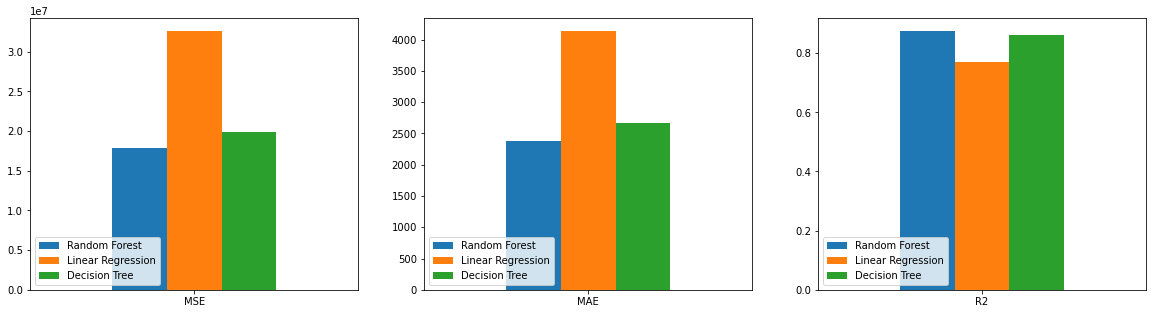

In [77]:
df_mse = pd.DataFrame({'Random Forest': RF_mse, 'Linear Regression': LR_mse, 'Decision Tree': DT_mse}, index=['MSE'])
df_mae = pd.DataFrame({'Random Forest': RF_mae, 'Linear Regression': LR_mae, 'Decision Tree': DT_mae}, index=['MAE'])
df_r2 = pd.DataFrame({'Random Forest': RF_r2, 'Linear Regression': LR_r2, 'Decision Tree': DT_r2}, index=['R2'])

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))

df_mse.plot.bar(rot=0, ax=axes[0])
axes[0].legend(loc='lower left')
df_mae.plot.bar(rot=0, ax=axes[1])
axes[1].legend(loc='lower left')
df_r2.plot.bar(rot=0, ax=axes[2])
axes[2].legend(loc='lower left')

plt.show()

**Random Forest is still the best regression model** to use since it has lower MSE and MAE, but higher R2 than the LR and BR. 

Decision tree performed the 2nd best. It has lower MSE and MAE than Linear Regression, but higher than RF. And it had higher R2 than LR, but lower than Random Forest. As expected, it didn't do as well as RF, but good to know that it still did better than Linear Regression.

Finally, Linear Regression did the worst since it had the highest MSE and MAE and lowest R2.

# Task 3

Add two dimensionality-reduction methods which are not used in CS5062 - Lab5 - Regression and Dimensionality Reduction.ipynb to the training pipelines for insurance.csv. Aim at dimensionality reduction techniques that are sufficiently different from the ones used in the example notebook. Draw conclusions from the results you observe in a markdown cell (max 250 words in a markdown cell).

*Exemplary*
- Two additional dimensionality reduction techniques attempted successfully. Both methods are different from the ones in the example notebook. Correct and insightful conclusion.

**NOTE**: Only updating the `param_grid` to include the 2 additional reduction techniques. All else remains the same as task 2.

Will be using **Linear Discriminant Analysis** (linear decision boundary with dimensionality component) and **Isomap** (non-linear dimensionality reduction) as my additional reduction techniques.

## Random Forest

In [73]:
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline),
                       ('reduce_dim', 'passthrough'),
                       ('regresson', RandomForestRegressor(n_estimators=10))])

# Other Options variables available in task 3
SOLVER_OPTIONS = ['svd', 'lsqr', 'eigen']
N_NEIGHBOURS_OPTIONS = [2, 5, 10, 15, 20]
METRIC_OPTIONS = ['minkowski','euclidean','manhattan']

param_grid = [
    {
        'reduce_dim': [PCA(iterated_power=7)],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'regresson__max_depth': MAX_DEPTH_OPTIONS
    },
    {
        'reduce_dim': [RFE(svm.SVR(kernel='linear', gamma='auto')), RFE(LinearRegression())],
        'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS,
        'regresson__max_depth': MAX_DEPTH_OPTIONS
    },
    {
        'reduce_dim': [LinearDiscriminantAnalysis(shrinkage='auto')],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'reduce_dim__solver': SOLVER_OPTIONS,
        'regresson__max_depth': MAX_DEPTH_OPTIONS
    },
    {
        'reduce_dim': [Isomap()],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'reduce_dim__n_neighbors': N_NEIGHBOURS_OPTIONS,
        'reduce_dim__metric': METRIC_OPTIONS,        
        'regresson__max_depth': MAX_DEPTH_OPTIONS
    }
]

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)

print("Best CV score = %0.4f:" % search.best_score_)
print("Best parameters: ", search.best_params_)


RF_best_params2 = search.best_params_
RF_best_model2 = search.best_estimator_

Best CV score = 0.8518:
Best parameters:  {'reduce_dim': RFE(estimator=SVR(gamma='auto', kernel='linear'), n_features_to_select=11), 'reduce_dim__n_features_to_select': 11, 'regresson__max_depth': 4}


## Linear Regression

In [74]:
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), 
                       ('reduce_dim', 'passthrough'),
                       ('regresson', LinearRegression())])

# Other Options variables available in task 3

param_grid = [
    {
        'reduce_dim': [PCA(iterated_power=7)],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'regresson__normalize': NORMALIZE_OPTIONS
    },
    {
        'reduce_dim': [RFE(svm.SVR(kernel='linear', gamma='auto')),RFE(LinearRegression())],
        'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS,
        'regresson__normalize': NORMALIZE_OPTIONS
    },
    {
        'reduce_dim': [LinearDiscriminantAnalysis(shrinkage='auto')],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'reduce_dim__solver': SOLVER_OPTIONS,
        'regresson__normalize': NORMALIZE_OPTIONS
    },
    {
        'reduce_dim': [Isomap()],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'reduce_dim__n_neighbors': N_NEIGHBOURS_OPTIONS,
        'reduce_dim__metric': METRIC_OPTIONS,         
        'regresson__normalize': NORMALIZE_OPTIONS
    }
]

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)
print("Best CV score = %0.4f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
LR_best_params2 = search.best_params_
LR_best_model2 = search.best_estimator_

Best CV score = 0.7371:
Best parameters:  {'reduce_dim': RFE(estimator=SVR(gamma='auto', kernel='linear'), n_features_to_select=6), 'reduce_dim__n_features_to_select': 6, 'regresson__normalize': True}


## Decision Tree

In [75]:
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline),
                       ('reduce_dim', 'passthrough'),
                       ('regresson', DecisionTreeRegressor())])

# Other Options variables available in task 3

param_grid = [
    {
        'reduce_dim': [PCA(iterated_power=7)],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'regresson__max_depth': MAX_DEPTH_OPTIONS,
        'regresson__criterion': CRITERION_OPTIONS,
    },
    {
        'reduce_dim': [RFE(svm.SVR(kernel='linear', gamma='auto')), RFE(LinearRegression())],
        'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS,
        'regresson__max_depth': MAX_DEPTH_OPTIONS,
        'regresson__criterion': CRITERION_OPTIONS,
    },
    {
        'reduce_dim': [LinearDiscriminantAnalysis(shrinkage='auto')],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'reduce_dim__solver': SOLVER_OPTIONS,
        'regresson__max_depth': MAX_DEPTH_OPTIONS,
        'regresson__criterion': CRITERION_OPTIONS,
    },
    {
        'reduce_dim': [Isomap()],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'reduce_dim__n_neighbors': N_NEIGHBOURS_OPTIONS,
        'reduce_dim__metric': METRIC_OPTIONS,         
        'regresson__max_depth': MAX_DEPTH_OPTIONS,
        'regresson__criterion': CRITERION_OPTIONS,
    }    
]

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)
print("Best CV score = %0.4f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
DT_best_params2 = search.best_params_
DT_best_model2 = search.best_estimator_

Best CV score = 0.8411:
Best parameters:  {'reduce_dim': RFE(estimator=SVR(gamma='auto', kernel='linear'), n_features_to_select=6), 'reduce_dim__n_features_to_select': 6, 'regresson__criterion': 'friedman_mse', 'regresson__max_depth': 4}


## Comparison

Task 2 Scores


Random Forest        Linear  Decision Tree
MSE   1.780119e+07  3.260676e+07   1.988726e+07
MAE   2.376836e+03  4.137875e+03   2.669559e+03
R2    8.751804e-01  7.713658e-01   8.605532e-01


Task 3 Scores


Random Forest        Linear  Decision Tree
MSE   1.831054e+07  3.260676e+07   1.988726e+07
MAE   2.457571e+03  4.137875e+03   2.669559e+03
R2    8.716090e-01  7.713658e-01   8.605532e-01

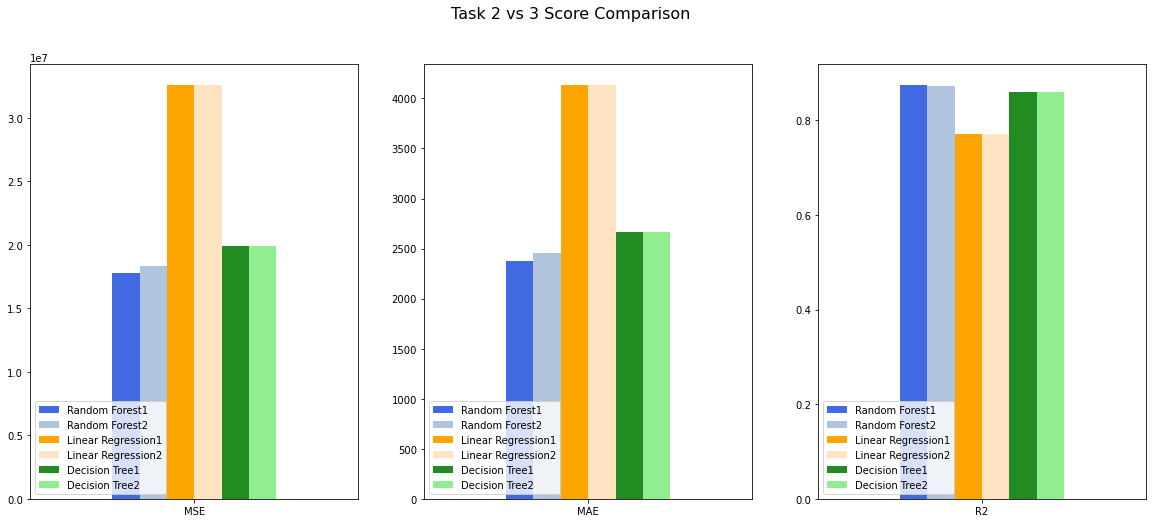

In [76]:
# From task 2
RF_mse2, RF_mae2, RF_r22 = evaluate_model(X_test, y_test, RF_best_model2)
LR_mse2, LR_mae2, LR_r22 = evaluate_model(X_test, y_test, LR_best_model2)
DT_mse2, DT_mae2, DT_r22 = evaluate_model(X_test, y_test, DT_best_model2)

RF_metrics2 = np.array([RF_mse2, RF_mae2, RF_r22])
LR_metrics2 = np.array([LR_mse2, LR_mae2, LR_r22])
DT_metrics2 = np.array([DT_mse2, DT_mae2, DT_r22])
df_metrics2 = pd.DataFrame({'Random Forest': RF_metrics2,
                          'Linear': LR_metrics2, 'Decision Tree': DT_metrics2}, index=index)
print('Task 2 Scores')
display(df_metrics)
print('')
print('Task 3 Scores')
display(df_metrics2)
print('')

colour_list = ['royalblue','lightsteelblue','orange','bisque','forestgreen','lightgreen']
    #darker colours are task 2, and lighter colours are task 3

df_mse2 = pd.DataFrame({'Random Forest1': RF_mse, 'Random Forest2': RF_mse2,'Linear Regression1': LR_mse, 'Linear Regression2': LR_mse2,'Decision Tree1': DT_mse,'Decision Tree2': DT_mse2}, index=['MSE'])
df_mae2 = pd.DataFrame({'Random Forest1': RF_mae, 'Random Forest2': RF_mae2,'Linear Regression1': LR_mae, 'Linear Regression2': LR_mae2,'Decision Tree1': DT_mae,'Decision Tree2': DT_mae2}, index=['MAE'])
df_r22 = pd.DataFrame({'Random Forest1': RF_r2, 'Random Forest2': RF_r22,'Linear Regression1': LR_r2, 'Linear Regression2': LR_r22,'Decision Tree1': DT_r2,'Decision Tree2': DT_r22}, index=['R2'])

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 8))
fig.suptitle('Task 2 vs 3 Score Comparison', fontsize=16)
df_mse2.plot.bar(rot=0, ax=axes[0], color = colour_list)
axes[0].legend(loc='lower left')
df_mae2.plot.bar(rot=0, ax=axes[1], color = colour_list)
axes[1].legend(loc='lower left')
df_r22.plot.bar(rot=0, ax=axes[2], color = colour_list)
axes[2].legend(loc='lower left')
plt.show()

In [72]:
print(RF_best_params)
print('')
print('')
print(RF_best_params2)

{'reduce_dim': RFE(estimator=LinearRegression(), n_features_to_select=11), 'reduce_dim__n_features_to_select': 11, 'regresson__max_depth': 4}


{'reduce_dim': RFE(estimator=SVR(gamma='auto', kernel='linear'), n_features_to_select=11), 'reduce_dim__n_features_to_select': 11, 'regresson__max_depth': 4}


In [78]:
print(LR_best_params)
print('')
print('')
print(LR_best_params2)

{'reduce_dim': RFE(estimator=SVR(gamma='auto', kernel='linear'), n_features_to_select=6), 'reduce_dim__n_features_to_select': 6, 'regresson__normalize': True}


{'reduce_dim': RFE(estimator=SVR(gamma='auto', kernel='linear'), n_features_to_select=6), 'reduce_dim__n_features_to_select': 6, 'regresson__normalize': True}


In [79]:
print(DT_best_params)
print('')
print('')
print(DT_best_params2)

{'reduce_dim': RFE(estimator=SVR(gamma='auto', kernel='linear'), n_features_to_select=6), 'reduce_dim__n_features_to_select': 6, 'regresson__criterion': 'friedman_mse', 'regresson__max_depth': 4}


{'reduce_dim': RFE(estimator=SVR(gamma='auto', kernel='linear'), n_features_to_select=6), 'reduce_dim__n_features_to_select': 6, 'regresson__criterion': 'friedman_mse', 'regresson__max_depth': 4}
